In [ ]:
!pip install torchmetrics
!pip install torchmetrics[detection]

In [1]:
import os 
import pandas as pd
import PIL as pil
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torchvision
from tqdm import tqdm
from torchmetrics.detection import MeanAveragePrecision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

In [2]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [26]:
path = "/dataset/BCCD/train"

In [27]:
df = pd.read_csv("/dataset/BCCD/train.csv")
df

,label,x1,y1,x2,y2,img
0,RBC,208,278,312,400,BloodImage_00154
1,RBC,247,232,351,337,BloodImage_00154
2,RBC,325,163,429,268,BloodImage_00154
3,RBC,257,105,361,210,BloodImage_00154
4,RBC,100,393,247,480,BloodImage_00154
...,...,...,...,...,...,...
4815,RBC,378,1,482,72,BloodImage_00090
4816,RBC,19,155,119,256,BloodImage_00090
4817,WBC,240,262,362,389,BloodImage_00090
4818,Platelets,402,72,440,113,BloodImage_00090


In [28]:
df = df[['img', 'label', 'x1', 'y1', 'x2', 'y2']]

In [29]:
unique_imgs = df.img.unique()
labels = df.label.unique()
labels

array(['RBC', 'WBC', 'Platelets'], dtype=object)

In [30]:
class custDat(torch.utils.data.Dataset):
    def __init__(self, df, unique_imgs, indices, path, class_labels):
        self.df = df
        self.unique_imgs = unique_imgs
        self.indices = indices
        self.path = path
        self.class_labels = class_labels

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        image_name = self.unique_imgs[self.indices[idx]]
        y = self.df[self.df.img == image_name]
        boxes = y.values[:, 2:].astype("float")
        labels = y.values[:, 1]
        img = pil.Image.open(self.path + "/" + image_name + ".jpg").convert('RGB')
        target = {}
        target["boxes"] = torch.tensor(boxes)
        target["label"] = torch.tensor([self.class_labels[label] for label in labels], dtype=torch.int64)
        return torchvision.transforms.ToTensor()(img), target

In [31]:
class_labels = {name:num+1 for num, name in enumerate(labels)}
class_labels

{'RBC': 1, 'WBC': 2, 'Platelets': 3}

In [32]:
train_inds , val_inds = train_test_split(range(unique_imgs.shape[0]),test_size=0.1)

In [33]:
def custom_collate(data):
    return data

In [34]:
next(iter(custDat(df, unique_imgs, train_inds, path, class_labels)))

(tensor([[[0.6471, 0.6471, 0.6471,  ..., 0.7686, 0.7529, 0.7333],
          [0.6471, 0.6471, 0.6471,  ..., 0.7647, 0.7490, 0.7333],
          [0.6431, 0.6431, 0.6431,  ..., 0.7569, 0.7451, 0.7294],
          ...,
          [0.7608, 0.7490, 0.7529,  ..., 0.7843, 0.7804, 0.7804],
          [0.7608, 0.7490, 0.7529,  ..., 0.7804, 0.7804, 0.7804],
          [0.7608, 0.7490, 0.7529,  ..., 0.7804, 0.7804, 0.7804]],
 
         [[0.5608, 0.5608, 0.5608,  ..., 0.7255, 0.7098, 0.6902],
          [0.5608, 0.5608, 0.5608,  ..., 0.7216, 0.7059, 0.6902],
          [0.5647, 0.5647, 0.5647,  ..., 0.7098, 0.6980, 0.6824],
          ...,
          [0.7765, 0.7647, 0.7686,  ..., 0.7961, 0.7922, 0.7922],
          [0.7765, 0.7647, 0.7686,  ..., 0.7922, 0.7922, 0.7922],
          [0.7765, 0.7647, 0.7686,  ..., 0.7922, 0.7922, 0.7922]],
 
         [[0.5725, 0.5725, 0.5686,  ..., 0.7569, 0.7412, 0.7216],
          [0.5725, 0.5725, 0.5686,  ..., 0.7529, 0.7373, 0.7216],
          [0.5725, 0.5725, 0.5686,  ...,

In [35]:
train_dl = torch.utils.data.DataLoader(custDat(df,unique_imgs,train_inds, path, class_labels),
                                       batch_size=8,
                                       shuffle=True,
                                       collate_fn=custom_collate,
                                       pin_memory=True if torch.cuda.is_available() else False)

val_dl = torch.utils.data.DataLoader(custDat(df,unique_imgs,val_inds, path, class_labels),
                                     batch_size=8,
                                     shuffle=True,
                                     collate_fn=custom_collate,
                                     pin_memory=True if torch.cuda.is_available() else False)

In [36]:
next(iter(train_dl))

[[tensor([[[0.6431, 0.6431, 0.6392,  ..., 0.7569, 0.7569, 0.7529],
           [0.6431, 0.6431, 0.6392,  ..., 0.7608, 0.7569, 0.7569],
           [0.6392, 0.6392, 0.6392,  ..., 0.7608, 0.7608, 0.7569],
           ...,
           [0.6902, 0.6902, 0.6902,  ..., 0.7843, 0.7804, 0.7804],
           [0.6902, 0.6902, 0.6902,  ..., 0.7882, 0.7804, 0.7765],
           [0.6902, 0.6902, 0.6902,  ..., 0.7882, 0.7804, 0.7765]],
  
          [[0.5608, 0.5608, 0.5569,  ..., 0.7412, 0.7412, 0.7373],
           [0.5608, 0.5608, 0.5569,  ..., 0.7451, 0.7412, 0.7412],
           [0.5569, 0.5608, 0.5608,  ..., 0.7451, 0.7451, 0.7412],
           ...,
           [0.5804, 0.5804, 0.5922,  ..., 0.7765, 0.7725, 0.7725],
           [0.5804, 0.5804, 0.5922,  ..., 0.7804, 0.7725, 0.7686],
           [0.5804, 0.5804, 0.5922,  ..., 0.7804, 0.7725, 0.7686]],
  
          [[0.6275, 0.6275, 0.6157,  ..., 0.8078, 0.8078, 0.8039],
           [0.6275, 0.6196, 0.6157,  ..., 0.8039, 0.8000, 0.8000],
           [0.6157, 0.

In [3]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=True)

/home/admins/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:
in_features=model.roi_heads.box_predictor.cls_score.in_features
num_classes=4
model.roi_heads.box_predictor =  FastRCNNPredictor(in_features,num_classes)
model

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [42]:
optimizer = torch.optim.SGD(model.parameters(),lr=0.001,momentum=0.9,weight_decay=0.005)

In [43]:
def train(model, optimizer, epochs, train_dataset, val_dataset, metric, device, threshold, callback={}, save_model=None):

    '''callback = {
        "ModelCheckpoint": {"filepath":"model_chkpt.pth"},
        "TerminateOnNaN": {"flag":True},
        }'''

    if save_model:
        model.load_state_dict(torch.load(save_model, map_location=device))

    train_acc_metric = metric(iou_type="bbox")
    val_acc_metric = metric(iou_type="bbox")
    model.to(device)

    #### Training Step Function ***************
    def train_step(inputs, labels):
        model.train()
        optimizer.zero_grad()
        loss_dict = model(inputs, labels)
        loss_value = sum(v for v in loss_dict.values())
        loss_value.backward()
        optimizer.step()
        return loss_value.detach().cpu().numpy()

    #### Loss Step Function ***************
    def loss_step(inputs, labels):
        model.train()
        optimizer.zero_grad()
        loss_dict = model(inputs, labels)
        val_predictions = sum(v.detach().cpu().numpy() for v in loss_dict.values())
        return val_predictions

    #### Accuracy Step Function **************
    def acc_step(inputs, targets, for_train=True):
      model.eval()
      with torch.no_grad():
        for img, targets in zip(inputs, targets):
          out = model([img])
          keep = torchvision.ops.nms(out[0]['boxes'], out[0]['scores'], threshold)
          outboxes = out[0]['boxes'][keep]
          outlabels = out[0]['labels'][keep]
          outscores = out[0]['scores'][keep]
          preds = [{'boxes':outboxes,'scores':outscores,'labels':outlabels}]
          target = [{'boxes':targets['boxes'],'labels':targets['labels']}]
          if for_train:
              train_acc_metric.update(preds,target)
          else:
              val_acc_metric.update(preds,target)

    history = {"train_accuracy":[], "val_accuracy":[], "train_loss":[], "val_loss":[]}
    train_lenght = len(train_dataset)
    val_length = len(val_dataset)

    #### Training Loop ***************
    for e in range(1, epochs+1):

        train_loss = 0  # Define the train loss.
        display = tqdm(train_dataset)  # display progress bar

        for batch in display:
            imgs = []
            targets = []

            for data in batch:
                imgs.append(data[0].to(device))
                targ = {}
                targ['boxes'] = data[1]['boxes'].to(device)
                targ['labels'] = data[1]['label'].to(device)
                targets.append(targ)

            batch_train_loss = train_step(imgs, targets)
            train_loss += batch_train_loss
            acc_step(imgs, targets)
            display.set_description(f"Epoch {e} Train Loss: {batch_train_loss:.6f} Tain Accuracy: {train_acc_metric.compute()['map'].item():.6f}")

            ### TerminateOnNaN Callback for trainnig loop.
            if callback.get("TerminateOnNaN") and torch.isnan(batch_train_loss):
                print("Terminate On NaN")
                return history  # Return the history.

        #### Validation Loop ***************
        val_loss = 0
        display = tqdm(val_dataset)

        for batch in display:
            imgs = []
            targets = []

            for data in batch:
                imgs.append(data[0].to(device))
                targ = {}
                targ['boxes'] = data[1]['boxes'].to(device)
                targ['labels'] = data[1]['label'].to(device)
                targets.append(targ)

            val_loss += loss_step(imgs, targets)
            acc_step(imgs, targets, for_train=False)
            display.set_description(f"Val Loss: {val_loss/val_length :.6f} Val Accuracy: {val_acc_metric.compute()['map'].item():.6f}")

        history["train_accuracy"].append(train_acc_metric.compute()['map'].item())
        history["val_accuracy"].append(val_acc_metric.compute()['map'].item())
        history["train_loss"].append(train_loss/train_lenght)
        history["val_loss"].append(val_loss/val_length)

        ####  ModelCheckpoint Callbacks ***************
        if callback.get("ModelCheckpoint"):
            path = callback["ModelCheckpoint"]["filepath"]  # path of the model.
            torch.save(model.state_dict(), path)  # Save the best model.
            print("Model saved.")


        train_acc_metric.reset()  # reset training metric
        val_acc_metric.reset() ### reset validation metric

        print()  # new line

    return history  # Return the history.

In [44]:
history = train(model, optimizer, 20, train_dl, val_dl, MeanAveragePrecision, device, threshold=0.20, callback={
        "ModelCheckpoint": {"filepath":"chkpt/model.pth"},
}, save_model=None)

Epoch 1 Train Loss: 0.887675 Tain Accuracy: 0.119694: 100%|██████████| 41/41 [02:41<00:00,  3.94s/it]
Val Loss: 0.857445 Val Accuracy: 0.159385: 100%|██████████| 5/5 [00:06<00:00,  1.22s/it]


Model saved.



Epoch 2 Train Loss: 0.533790 Tain Accuracy: 0.384011: 100%|██████████| 41/41 [02:30<00:00,  3.67s/it]
Val Loss: 0.645018 Val Accuracy: 0.498003: 100%|██████████| 5/5 [00:05<00:00,  1.20s/it]


Model saved.



Epoch 3 Train Loss: 0.560560 Tain Accuracy: 0.547177: 100%|██████████| 41/41 [02:27<00:00,  3.59s/it]
Val Loss: 0.586816 Val Accuracy: 0.551826: 100%|██████████| 5/5 [00:06<00:00,  1.20s/it]


Model saved.



Epoch 4 Train Loss: 0.562159 Tain Accuracy: 0.581330: 100%|██████████| 41/41 [02:26<00:00,  3.58s/it]
Val Loss: 0.567758 Val Accuracy: 0.555171: 100%|██████████| 5/5 [00:05<00:00,  1.19s/it]


Model saved.



Epoch 5 Train Loss: 0.541354 Tain Accuracy: 0.598416: 100%|██████████| 41/41 [02:25<00:00,  3.56s/it]
Val Loss: 0.561636 Val Accuracy: 0.567132: 100%|██████████| 5/5 [00:05<00:00,  1.19s/it]


Model saved.



Epoch 6 Train Loss: 0.575858 Tain Accuracy: 0.609548: 100%|██████████| 41/41 [02:24<00:00,  3.52s/it]
Val Loss: 0.548275 Val Accuracy: 0.575983: 100%|██████████| 5/5 [00:05<00:00,  1.19s/it]


Model saved.



Epoch 7 Train Loss: 0.507482 Tain Accuracy: 0.615352: 100%|██████████| 41/41 [02:23<00:00,  3.49s/it]
Val Loss: 0.545664 Val Accuracy: 0.582650: 100%|██████████| 5/5 [00:05<00:00,  1.18s/it]


Model saved.



Epoch 8 Train Loss: 0.431419 Tain Accuracy: 0.627123: 100%|██████████| 41/41 [02:24<00:00,  3.52s/it]
Val Loss: 0.537915 Val Accuracy: 0.583913: 100%|██████████| 5/5 [00:05<00:00,  1.19s/it]


Model saved.



Epoch 9 Train Loss: 0.466327 Tain Accuracy: 0.630819: 100%|██████████| 41/41 [02:21<00:00,  3.46s/it]
Val Loss: 0.533967 Val Accuracy: 0.587033: 100%|██████████| 5/5 [00:05<00:00,  1.18s/it]


Model saved.



Epoch 10 Train Loss: 0.411518 Tain Accuracy: 0.631084: 100%|██████████| 41/41 [02:23<00:00,  3.50s/it]
Val Loss: 0.523307 Val Accuracy: 0.595239: 100%|██████████| 5/5 [00:05<00:00,  1.18s/it]


Model saved.



Epoch 11 Train Loss: 0.435722 Tain Accuracy: 0.635985: 100%|██████████| 41/41 [02:23<00:00,  3.49s/it]
Val Loss: 0.541734 Val Accuracy: 0.582953: 100%|██████████| 5/5 [00:05<00:00,  1.17s/it]


Model saved.



Epoch 12 Train Loss: 0.471568 Tain Accuracy: 0.642561: 100%|██████████| 41/41 [02:21<00:00,  3.46s/it]
Val Loss: 0.523261 Val Accuracy: 0.578204: 100%|██████████| 5/5 [00:05<00:00,  1.19s/it]


Model saved.



Epoch 13 Train Loss: 0.327610 Tain Accuracy: 0.649927: 100%|██████████| 41/41 [02:21<00:00,  3.46s/it]
Val Loss: 0.514313 Val Accuracy: 0.592247: 100%|██████████| 5/5 [00:05<00:00,  1.18s/it]


Model saved.



Epoch 14 Train Loss: 0.500280 Tain Accuracy: 0.651946: 100%|██████████| 41/41 [02:20<00:00,  3.43s/it]
Val Loss: 0.524213 Val Accuracy: 0.593134: 100%|██████████| 5/5 [00:05<00:00,  1.17s/it]


Model saved.



Epoch 15 Train Loss: 0.379232 Tain Accuracy: 0.654350: 100%|██████████| 41/41 [02:21<00:00,  3.46s/it]
Val Loss: 0.509705 Val Accuracy: 0.599004: 100%|██████████| 5/5 [00:05<00:00,  1.18s/it]


Model saved.



Epoch 16 Train Loss: 0.484296 Tain Accuracy: 0.659230: 100%|██████████| 41/41 [02:20<00:00,  3.43s/it]
Val Loss: 0.517218 Val Accuracy: 0.595770: 100%|██████████| 5/5 [00:05<00:00,  1.18s/it]


Model saved.



Epoch 17 Train Loss: 0.345444 Tain Accuracy: 0.661593: 100%|██████████| 41/41 [02:20<00:00,  3.42s/it]
Val Loss: 0.518156 Val Accuracy: 0.582343: 100%|██████████| 5/5 [00:05<00:00,  1.18s/it]


Model saved.



Epoch 18 Train Loss: 0.357489 Tain Accuracy: 0.667103: 100%|██████████| 41/41 [02:20<00:00,  3.42s/it]
Val Loss: 0.533939 Val Accuracy: 0.592363: 100%|██████████| 5/5 [00:05<00:00,  1.20s/it]


Model saved.



Epoch 19 Train Loss: 0.291323 Tain Accuracy: 0.673349: 100%|██████████| 41/41 [02:20<00:00,  3.42s/it]
Val Loss: 0.520157 Val Accuracy: 0.584049: 100%|██████████| 5/5 [00:05<00:00,  1.18s/it]


Model saved.



Epoch 20 Train Loss: 0.339395 Tain Accuracy: 0.675456: 100%|██████████| 41/41 [02:20<00:00,  3.43s/it]
Val Loss: 0.527965 Val Accuracy: 0.583985: 100%|██████████| 5/5 [00:05<00:00,  1.17s/it]


Model saved.



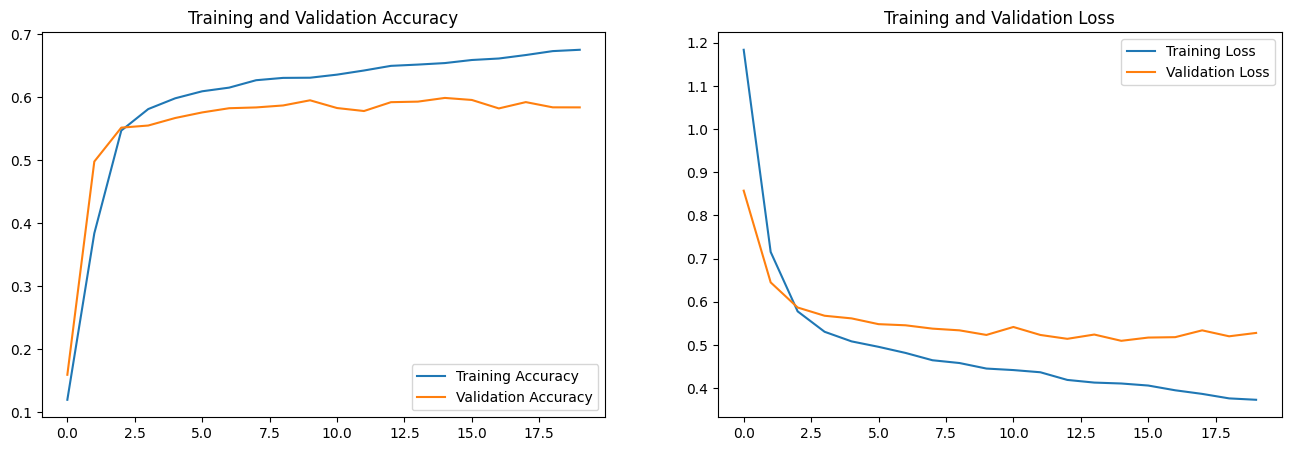

In [49]:
## Plot the accuracy and loss

acc = history['train_accuracy']
val_acc = history['val_accuracy']
loss = history['train_loss']
val_loss = history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [7]:
def draw_box(img, boxes, labels, class_colors, cfont=False):
    img = pil.Image.fromarray(img)
    draw = pil.ImageDraw.Draw(img, "RGBA")
    if cfont:
        font = pil.ImageFont.truetype("NotoSans-VariableFont_wdth,wght.ttf", 12)
    else:
        font = None 
    for box, label in zip(boxes, labels):
        x1, y1, x2, y2 = box
        label = label.cpu().numpy().item()
        name = class_colors[label][0]
        color = class_colors[label][1]
        fill_color = class_colors[label][2]
        draw.rectangle(list([x1, y1-20, x2, y1]), fill=color, outline=color)
        draw.text([(x1+x2)/2, (y1-20+y1)/2], name, 'black', anchor='mm', font=font)
        draw.rectangle(list([x1, y1, x2, y2]), fill=fill_color, outline=color)
    return img

In [8]:
def test(model, path, device, threshold, class_colors, custom_font):
    model.to(device)
    model.eval()
    with torch.no_grad():
        for img_name in os.listdir(path):
            img = torchvision.transforms.ToTensor()(pil.Image.open(path + "/" + img_name).convert('RGB'))
            out = model([img.to(device)])
            keep = torchvision.ops.nms(out[0]['boxes'], out[0]['scores'], threshold)
            im = (img.permute(1,2,0).cpu().detach().numpy()*255).astype('uint8')
            img = draw_box(im, out[0]['boxes'][keep], out[0]['labels'][keep], class_colors, custom_font)
            plt.figure(figsize=(10, 10))
            plt.axis(False)
            plt.imshow(img)
            plt.show()

In [9]:
class_colors = {
    1:['RBC', 'red', (80, 0, 0, 40)],
    2:['WBC', 'green', (0, 80, 0, 40)],
    3:['PLT', 'blue', (0, 0, 80, 40)],
}

In [5]:
model.load_state_dict(torch.load("chkpt/bccd_model.pth", map_location=device))

<All keys matched successfully>

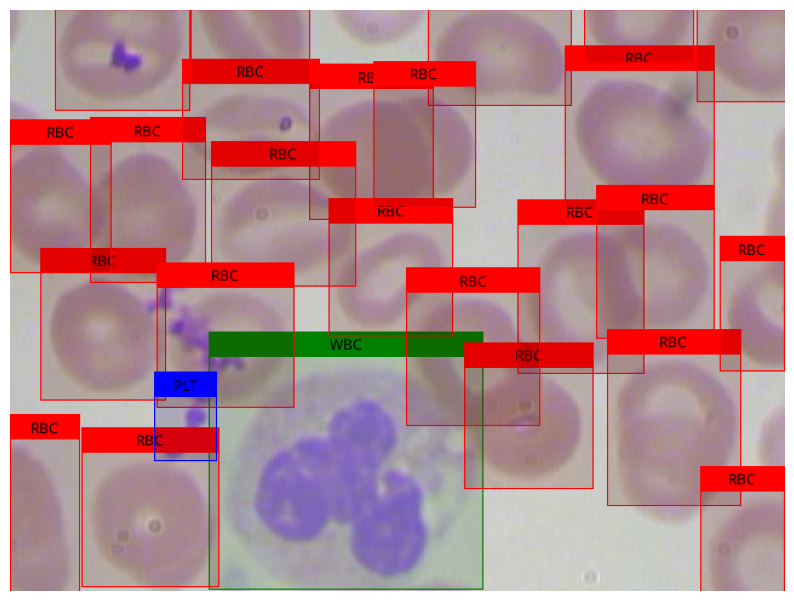

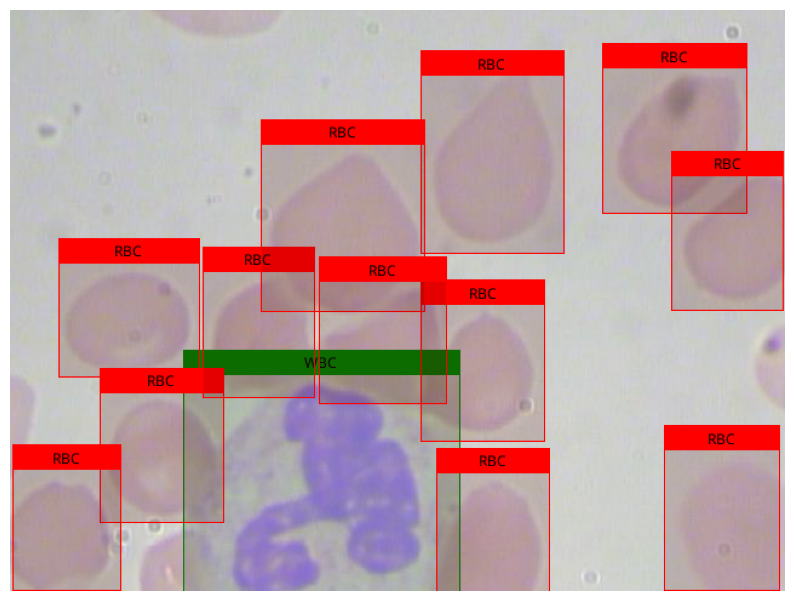

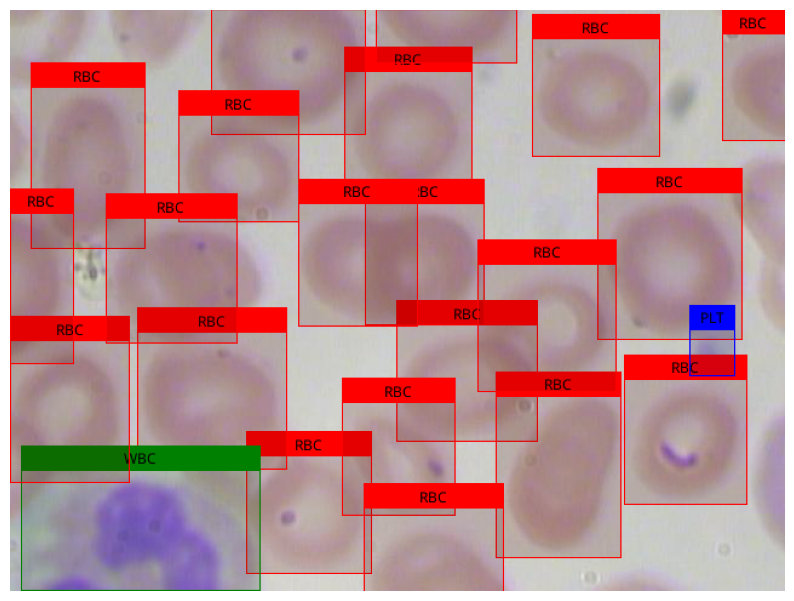

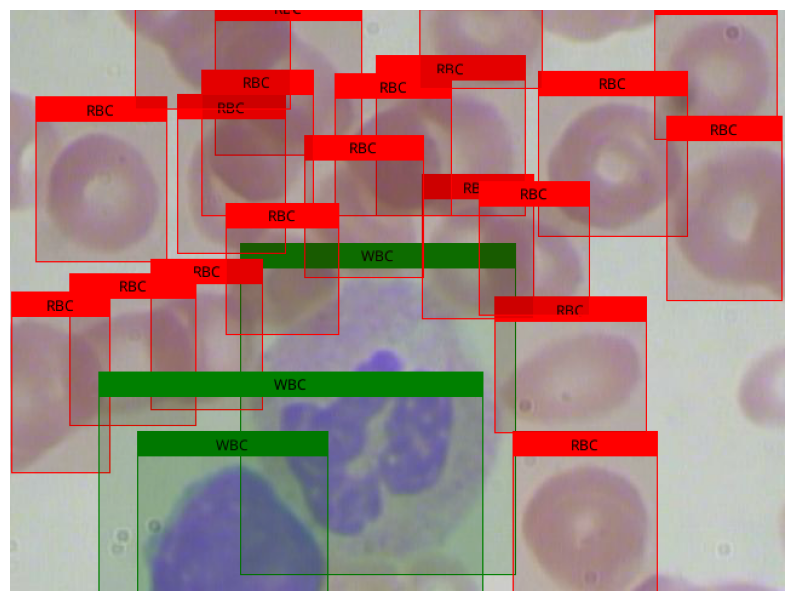

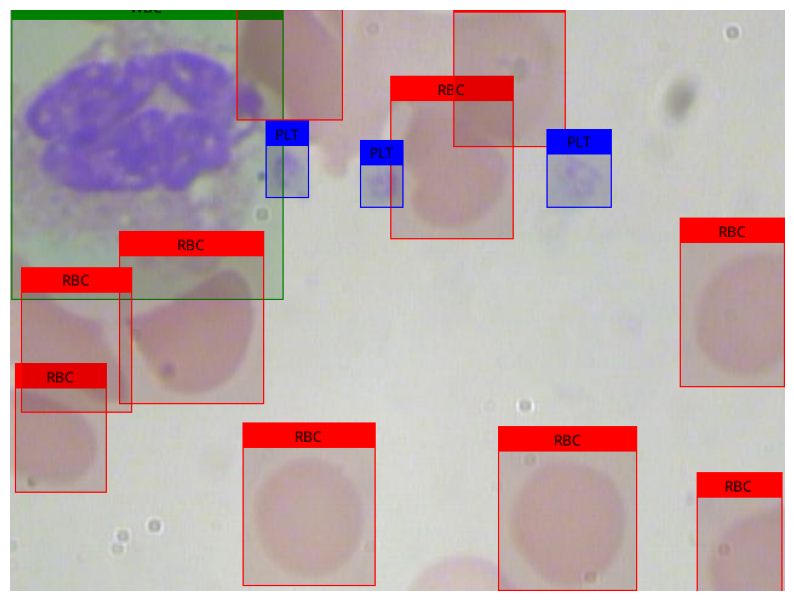

In [12]:
test(model, "dataset/BCCD/test", device, 0.45, class_colors, custom_font=True)